## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [8]:
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Order/Giraff_ai_lab/final_leap

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Order/Giraff_ai_lab/final_leap


In [9]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

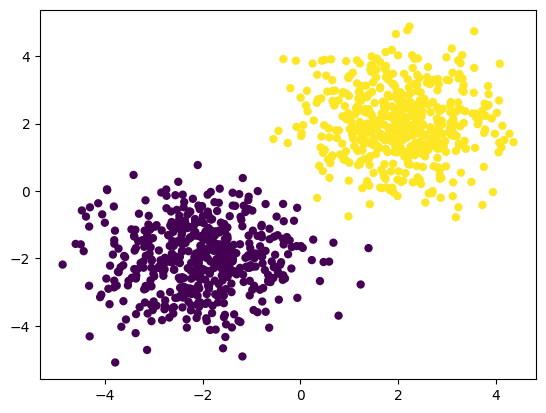

In [10]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [11]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [12]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [13]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

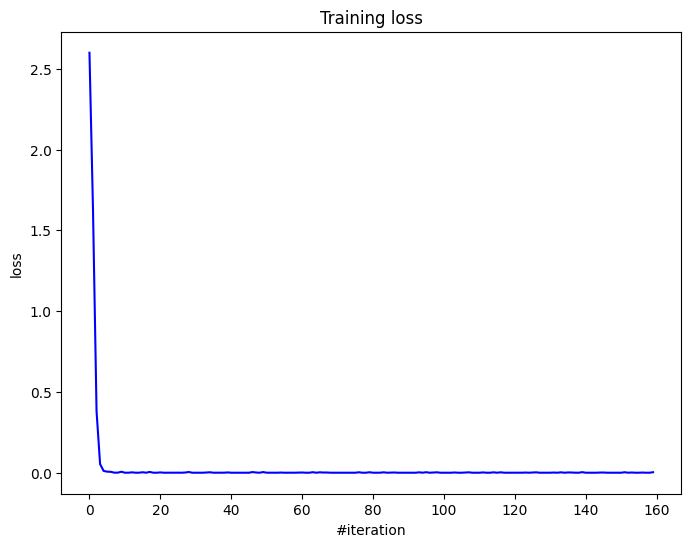

Current loss: 0.003014


In [14]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [54]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [55]:
# convert to one hot
y_test = np.eye(10)[y_test]
y_train = np.eye(10)[y_train]

In [56]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000, 10))

Add validation sample:

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000, random_state=69)

In [59]:
X_train.shape, y_train.shape

((50000, 28, 28), (50000, 10))

One-hot encode the labels first.

In [60]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
# y_train = np.array(enc.fit_transform(y_train.reshape(-1, 1)).todense())
# y_val = np.array(enc.transform(y_val.reshape(-1, 1)).todense())
# y_test = np.array(enc.transform(y_test.reshape(-1, 1)).todense())

image_size = 28**2
X_train = X_train.reshape(X_train.shape[0], image_size)
X_val = X_val.reshape(X_val.shape[0], image_size)
X_test = X_test.reshape(X_test.shape[0], image_size)

In [61]:
X_train.shape, y_train.shape

((50000, 784), (50000, 10))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

In [62]:
# Your code goes here. ################################################

def train(net, optimizer):
    history_loss = []
    for _ in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            optimizer(net.getParameters(),
                        net.getGradParameters(),
                        optimizer_config,
                        optimizer_state)
            history_loss.append(loss)
    return history_loss

## ReLU

In [63]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(ReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_relu = train(net, sgd_momentum)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax

CPU times: user 47.8 s, sys: 1min 4s, total: 1min 52s
Wall time: 1min 11s


## ELU

In [64]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(ELU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_elu = train(net, sgd_momentum)

Linear 784 -> 128
ELU
Linear 128 -> 10
LogSoftMax



<ipython-input-9-667f9b903245>:11: RuntimeWarning: overflow encountered in exp
  exp = np.exp(input) - 1
<ipython-input-9-667f9b903245>:12: RuntimeWarning: invalid value encountered in multiply
  self.output = input * right_side + self.alpha * exp * left_side


CPU times: user 47.8 s, sys: 1min 3s, total: 1min 51s
Wall time: 1min 11s


## LeakyReLU

In [65]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(LeakyReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_relu_l = train(net, sgd_momentum)

Linear 784 -> 128
LeakyReLU
Linear 128 -> 10
LogSoftMax



<ipython-input-9-ed6f59e6373e>:7: RuntimeWarning: invalid value encountered in subtract
  self.output = np.subtract(input, input.max(axis=1, keepdims=True))
<ipython-input-9-e1890468234e>:9: RuntimeWarning: invalid value encountered in multiply
  self.output = -np.sum(input * target) / size
<ipython-input-9-ed6f59e6373e>:16: RuntimeWarning: invalid value encountered in subtract
  out = input - input.max(axis=1, keepdims=True)


KeyboardInterrupt: ignored

## SoftPlus

In [66]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(SoftPlus())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_soft_plus = train(net, sgd_momentum)

Linear 784 -> 128
SoftPlus
Linear 128 -> 10
LogSoftMax



<ipython-input-9-1635f32527b3>:7: RuntimeWarning: overflow encountered in exp
  exp = np.exp(input)
<ipython-input-9-1635f32527b3>:13: RuntimeWarning: overflow encountered in exp
  minus_exp = np.exp(-input)


KeyboardInterrupt: ignored

## ReLU + BatchNormalization

In [67]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_relu = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 10
LogSoftMax



KeyboardInterrupt: ignored

## ELU + BatchNorm

In [68]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ELU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_elu = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ELU
Linear 128 -> 10
LogSoftMax



KeyboardInterrupt: ignored

## LeakyReLU + BatchNorm

In [69]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(LeakyReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_l_Relu = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 128 -> 10
LogSoftMax



KeyboardInterrupt: ignored

## SoftPlus + BatchNorm

In [70]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(SoftPlus())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_softplus = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 128 -> 10
LogSoftMax



KeyboardInterrupt: ignored

NameError: ignored

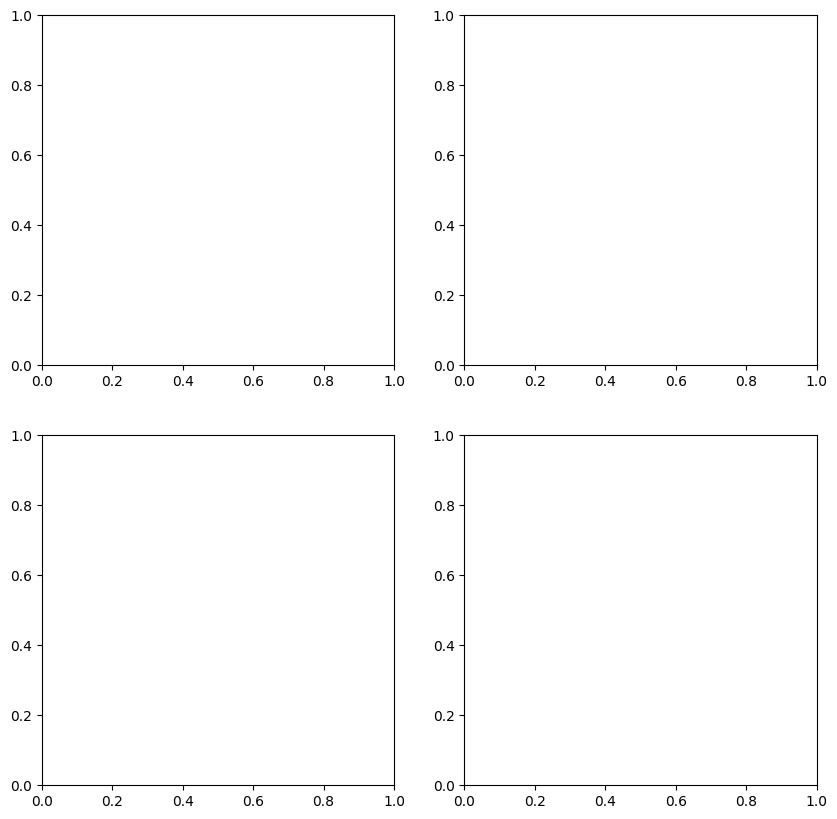

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].semilogy(loss_history_batchn_softplus, label='BatchNorm')
axs[0, 0].semilogy(loss_history_soft_plus, label='Without')
axs[0, 0].set_title('Soft Plus')

axs[0, 1].semilogy(loss_history_batchn_relu)
axs[0, 1].semilogy(loss_history_relu)
axs[0, 1].set_title('ReLU')

axs[1, 0].semilogy(loss_history_batchn_l_Relu)
axs[1, 0].semilogy(loss_history_relu_l)
axs[1, 0].set_title('LeakyReLU')

axs[1, 1].semilogy(loss_history_batchn_elu)
axs[1, 1].semilogy(loss_history_elu)
axs[1, 1].set_title('ELU')

for ax in axs.flat:
    ax.set(xlabel='#iteration', ylabel='Training loss')
fig.legend();

## Adam Oprimizer

In [ ]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(ReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'beta1': 0.97, 'beta2': 0.98, 'epsilon': 1e-2}
optimizer_state = {}
loss_history_adam_relu = train(net, adam_optimizer)

In [ ]:
plt.semilogy(loss_history_adam_relu, label='Adam')
plt.semilogy(loss_history_relu, label='SGD')
plt.xlabel('#iteration')
plt.ylabel('Training loss')
plt.legend();

In [ ]:
loss_history_adam_relu[-1]

In [ ]:
plt.semilogy(loss_history_soft_plus, label='Soft Plus')

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

It will be easier to work with pytorch

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [75]:
from torch import nn
import torch
from torchvision.datasets import MNIST

In [76]:
train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 52576436.86it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 48415545.09it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21840668.61it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18317816.12it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [77]:
train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

It's the same dataset.

In [78]:
train_mnist_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

In [79]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.activation = nn.LeakyReLU(negative_slope=0.1)
        self.dropout = nn.Dropout(p=0.2)

        self.lin1 = nn.Linear(784, 128)

        self.lin2 = nn.Linear(128, 128, (3, 3))

        self.fc = nn.Linear(128, 10, bias=True)

    def forward(self, x):
        x = self.lin1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.lin2(x)
        x = self.activation(x)

        x = self.fc(x)
        return x

In [80]:
predicted_labels = []
real_labels = []
model = MyNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

for epoch in range(epochs):
    running_loss = 0.
    for batch in train_data_loader:
        optimizer.zero_grad()

        y_predicted = model(batch[0].reshape(-1, 784))

        loss = loss_fn(y_predicted, batch[1])
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

    print(f'Epoch: {epoch+1}, Train loss: {running_loss:.5f}')


Epoch: 1, Train loss: 595.37358
Epoch: 2, Train loss: 318.45207
Epoch: 3, Train loss: 271.58884
Epoch: 4, Train loss: 248.79567
Epoch: 5, Train loss: 236.65485
Epoch: 6, Train loss: 226.36811
Epoch: 7, Train loss: 225.75231
Epoch: 8, Train loss: 219.61725
Epoch: 9, Train loss: 215.66110
Epoch: 10, Train loss: 215.33293


predict

In [83]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

Print here your accuracy on test set. It should be around 90%.

In [85]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9726
